## Foreword & Libraries

This notebook merges the RandomForest attempts and lessons I've learned over the course of the project. 

The data used here was pre-processed by Michael, who did an amazing at identifiying columns rich with meaningful features. The discovery, graphs, analysis and models are all my own.

In [1]:
# Data Processing
import numpy as np
import pandas as pd
from pathlib import Path

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report, r2_score
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.stats import randint

# Resampling
from imblearn.under_sampling import RandomUnderSampler

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

## Train Test Split & First Model

In [3]:
# This data was cleaned and pre-processed by Michael Cummings
# Chose to load this due to higher metrics  

file = "Resources/Flight_Processed.csv"
df = pd.read_csv(file)

df.head(10)

,Flight_Number_Operating_Airline,Month,DayofMonth,DayOfWeek,OriginAirportID,CRSDepTime,DepTime,DestAirportID,CRSArrTime,ArrTime,Status
0,4301,4,4,1,11921,1133,1123,11292,1245,1228,0
1,4299,4,4,1,12206,732,728,12266,849,848,0
2,4298,4,4,1,11413,1529,1514,11292,1639,1636,0
3,4296,4,4,1,12266,1435,1430,11973,1605,1547,0
4,4295,4,4,1,11413,1135,1135,11292,1245,1251,0
5,4294,4,4,1,11292,955,952,15370,1240,1238,0
6,4293,4,4,1,12266,2139,2136,12915,2231,2218,0
7,4292,4,4,1,15412,1129,1117,12266,1306,1311,0
8,4291,4,4,1,12266,1424,1414,10185,1524,1513,0
9,4290,4,4,1,12266,954,947,13422,1121,1110,0


In [4]:
# Split our preprocessed data into our features and target arrays
y = df.Status
X = df.drop(columns=["Status", "ArrTime", "DepTime"])

# Removed Arr and Dep from features

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [5]:
X.head()

,Flight_Number_Operating_Airline,Month,DayofMonth,DayOfWeek,OriginAirportID,CRSDepTime,DestAirportID,CRSArrTime
0,4301,4,4,1,11921,1133,11292,1245
1,4299,4,4,1,12206,732,12266,849
2,4298,4,4,1,11413,1529,11292,1639
3,4296,4,4,1,12266,1435,11973,1605
4,4295,4,4,1,11413,1135,11292,1245


In [6]:
# Converting labels to arrays

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [7]:
# Generate a RandomForest model to find baseline. 

RFBase_Model = RandomForestClassifier(random_state = 1, n_jobs=8)
RFBase_Model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=8, random_state=1)

In [8]:
RFBase_pred = RFBase_Model.predict(X_test)

In [9]:
# Print the balanced_accuracy score of the model
accu_score = balanced_accuracy_score(y_test, RFBase_pred)
c_matrix = confusion_matrix(y_test, RFBase_pred)

print(accu_score)
print(c_matrix)

0.4690789260489152
[[415483  81507    538]
 [159567 133561    903]
 [ 12194   9069   2842]]


In [10]:
target_names = ['On_Time', 'Delayed', 'Cancelled']
print(classification_report(y_test, RFBase_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.71      0.84      0.77    497528
     Delayed       0.60      0.45      0.52    294031
   Cancelled       0.66      0.12      0.20     24105

    accuracy                           0.68    815664
   macro avg       0.66      0.47      0.49    815664
weighted avg       0.67      0.68      0.66    815664



## GridsearchCV

In [10]:
rf_model = RandomForestClassifier(random_state = 1)
rf_param_grid = { 
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth' : [2, 8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rf_model = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid)
CV_rf_model.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=1),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [8],
                         'max_features': ['sqrt'], 'n_estimators': [200]})

In [ ]:
CViter1 = CV_rf_model.best_params_
print(CViter1)

{'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 200}


In [11]:

rf_param_grid2 = { 
    'n_estimators': [200, 500],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [2, 8]
}

In [146]:
CV_rf_model_2 = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid2, n_jobs = 16)
CV_rf_model_2.fit(X_train, y_train)

In [14]:
CViter2 = CV_rf_model_2.best_params_
print(CViter2)

{'max_features': 'log2', 'min_samples_leaf': 8, 'n_estimators': 200}


## Testing RF Models with Searched Params

### Model 1, n200

In [13]:
rfGS1_model = RandomForestClassifier(random_state = 1,
                                    n_estimators=200,
                                    criterion = 'entropy',
                                    max_features='log2',
                                    n_jobs = 8
                                    )
rfGS1_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=200, n_jobs=8, random_state=1)

In [14]:
rfGS1_pred = rfGS1_model.predict(X_test)

In [16]:
print(classification_report(y_test, rfGS1_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.71      0.84      0.77    497528
     Delayed       0.60      0.45      0.52    294031
   Cancelled       0.65      0.17      0.27     24105

    accuracy                           0.68    815664
   macro avg       0.65      0.49      0.52    815664
weighted avg       0.67      0.68      0.66    815664



### Model 2, n200depth8

In [ ]:
rfGS2_model = RandomForestClassifier(random_state = 1, 
                                    n_esitmators=200,
                                    criterion='entropy', 
                                    max_depth=8, 
                                    max_features='log2', 
                                    n_jobs = 8)
rfGS2_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, max_features='log2',
                       n_estimators=200, random_state=1)

In [ ]:
rfGS2_pred = rfGS2_model.predict(X_test)

In [ ]:
print(classification_report(y_test, rfGS2_pred, target_names=target_names))

c:\Users\aldod\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     On_Time       0.66      0.86      0.75    498002
     Delayed       0.57      0.32      0.41    293712
   Cancelled       0.00      0.00      0.00     23950

    accuracy                           0.64    815664
   macro avg       0.41      0.40      0.39    815664
weighted avg       0.61      0.64      0.61    815664



c:\Users\aldod\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\aldod\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Model 3, n200m8

In [17]:
rfGS3_model = RandomForestClassifier(random_state = 1,
                                    n_estimators=200,
                                    criterion = 'entropy',
                                    min_samples_leaf=8,
                                    n_jobs = 16
                                    )
rfGS3_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=8,
                       n_estimators=200, n_jobs=16, random_state=1)

In [18]:
rfGS3_pred = rfGS3_model.predict(X_test)

In [19]:
target_names = ['On_Time', 'Delayed', 'Cancelled']
print(classification_report(y_test, rfGS3_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.70      0.87      0.78    497528
     Delayed       0.63      0.41      0.50    294031
   Cancelled       0.76      0.09      0.17     24105

    accuracy                           0.68    815664
   macro avg       0.70      0.46      0.48    815664
weighted avg       0.68      0.68      0.66    815664



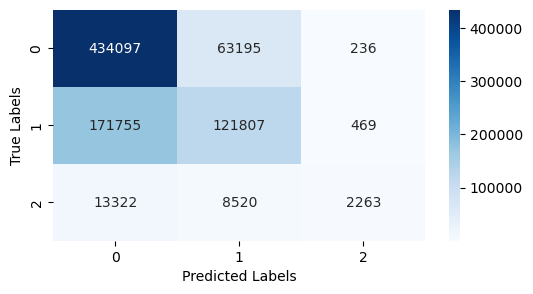

In [21]:
plt.figure(figsize = (6,3))
sns.heatmap(metrics.confusion_matrix(y_test, rfGS3_pred), annot = True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [22]:
# from joblib import dump, load
# dump(rfGS3_pred, 'RFn200m8_FlightStatus.joblib') 

['RFn200m8_FlightStatus.joblib']

### Model 4, n500

In [ ]:
rfGS4_model = RandomForestClassifier(random_state = 1,
                                    n_estimators=500,
                                    criterion = 'entropy',
                                    max_features='log2'
                                    n_jobs = 8,
                                    )
rfGS4_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=500, random_state=1)

In [ ]:
rfGS4_model_pred = rfGS4_model.predict(X_test)

In [ ]:
print(classification_report(y_test, rfGS4_model_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.71      0.84      0.77    498002
     Delayed       0.60      0.46      0.52    293712
   Cancelled       0.65      0.17      0.27     23950

    accuracy                           0.68    815664
   macro avg       0.65      0.49      0.52    815664
weighted avg       0.67      0.68      0.66    815664



### Model 5, n1500m24

In [10]:
RFn10m24 = RandomForestClassifier(random_state = 1,
                                    n_estimators=1500,
                                    criterion = 'entropy',
                                    min_samples_leaf=24,
                                    n_jobs = 16
                                    )
RFn10m24.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=24,
                       n_estimators=1500, n_jobs=16, random_state=1)

In [15]:
RFn10m24_pred = RFn10m24.predict(X_test)

c:\Users\aldod\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
target_names = ['On_Time', 'Delayed', 'Cancelled']
print(classification_report(y_test, RFn10m24_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.69      0.88      0.77    497528
     Delayed       0.62      0.39      0.48    294031
   Cancelled       0.78      0.05      0.10     24105

    accuracy                           0.68    815664
   macro avg       0.70      0.44      0.45    815664
weighted avg       0.67      0.68      0.65    815664



In [ ]:
from sklearn.metrics import precision_score
precision_score(y_test, RFn10m24_pred, average='macro')

0.6971575187027542

In [ ]:
# from joblib import dump, load
# dump(RFn10m24, 'RF1024_FlightStatus.joblib') 

['RFn1000_FlightStatus.joblib']

### Model 6, n200m4

In [28]:
RFn200m4 = RandomForestClassifier(random_state = 1,
                                    n_estimators=200,
                                    criterion = 'entropy',
                                    min_samples_leaf=4,
                                    n_jobs = 16
                                    )
RFn200m4.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=4,
                       n_estimators=200, n_jobs=16, random_state=1)

In [29]:
RFn200m4_pred = RFn200m4.predict(X_test)

In [30]:
print(classification_report(y_test, RFn200m4_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.71      0.87      0.78    497528
     Delayed       0.63      0.43      0.51    294031
   Cancelled       0.75      0.12      0.20     24105

    accuracy                           0.69    815664
   macro avg       0.69      0.47      0.50    815664
weighted avg       0.68      0.69      0.66    815664



In [31]:
RFn200m8 = RandomForestClassifier(random_state = 1,
                                    n_estimators=200,
                                    criterion = 'entropy',
                                    min_samples_leaf=8,
                                    n_jobs = 8
                                    )
RFn200m8.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=8,
                       n_estimators=200, n_jobs=8, random_state=1)

In [32]:
RFn200m8_pred = RFn200m8.predict(X_test)

In [33]:
print(classification_report(y_test, RFn200m4_pred, target_names=target_names))

              precision    recall  f1-score   support

     On_Time       0.71      0.87      0.78    497528
     Delayed       0.63      0.43      0.51    294031
   Cancelled       0.75      0.12      0.20     24105

    accuracy                           0.69    815664
   macro avg       0.69      0.47      0.50    815664
weighted avg       0.68      0.69      0.66    815664



## Data Resampling

In [55]:
# Beware of conflicts with imblearn if SKlearn 1.3.0 is installed, fixed by downgrading SKlearn to 1.2.2
import imblearn
import sklearn
from imblearn.under_sampling import NearMiss
print(imblearn.__version__)
print(sklearn.__version__)


0.10.1
1.2.2


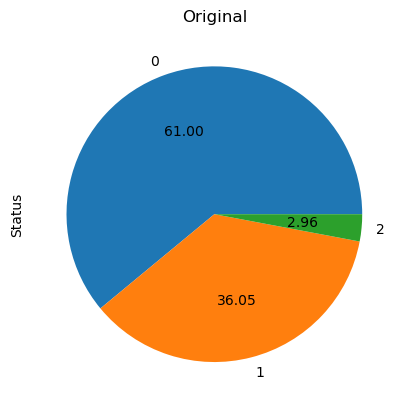

In [53]:
autopct = "%.2f"
ax = y.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("Original")

In [27]:
y.value_counts()

0    2487640
1    1470155
2     120523
Name: Status, dtype: int64

In [32]:
undersample = NearMiss(version=3)
X_RUS, y_RUS = undersample.fit_resample(X, y)

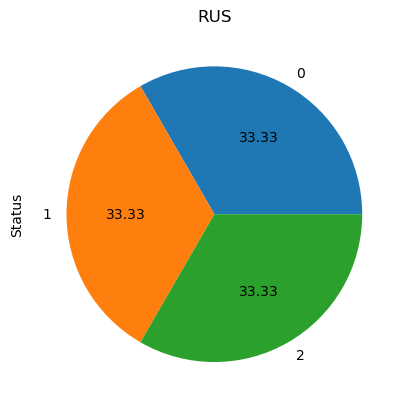

In [105]:
ax = y_RUS.value_counts().plot.pie(autopct=autopct)
_ = ax.set_title("RUS")

In [34]:
# Split the preprocessed data into a training and testing dataset
X_RUS_train, X_RUS_test, y_RUS_train, y_RUS_test = train_test_split(X_RUS, y_RUS, test_size=0.2,random_state=42)

In [43]:
RFTuned_ModelRUS = RandomForestClassifier(random_state = 1,
                                    n_estimators=1000,
                                    criterion = 'entropy',
                                    min_samples_leaf=8,
                                    n_jobs = 16
                                    )
RFTuned_ModelRUS.fit(X_RUS_train, y_RUS_train)

RandomForestClassifier(criterion='entropy', min_samples_leaf=8,
                       n_estimators=1000, n_jobs=16, random_state=1)

In [44]:
RFTuned_RUS_pred = RFTuned_ModelRUS.predict(X_RUS_test)

In [45]:
# Model with RUS data
print(classification_report(y_RUS_test, RFTuned_RUS_pred, target_names=target_names))

# Is our original model overfitting or are we lacking data for the new model?
# What solutions can we find?


              precision    recall  f1-score   support

     On_Time       0.52      0.53      0.52     24176
     Delayed       0.46      0.42      0.44     24054
   Cancelled       0.64      0.69      0.66     24084

    accuracy                           0.54     72314
   macro avg       0.54      0.54      0.54     72314
weighted avg       0.54      0.54      0.54     72314



## Further Evaluation of RF Model 3 and 5

In [12]:
# Split our preprocessed data into our features and target arrays

y = df.Status
X = df.drop(columns=["Status", "ArrTime", "DepTime"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

In [26]:
RFn10m24_pred = RFTuned_Model.predict(X_test)

target_names = ['On_Time', 'Delayed', 'Cancelled']
print(classification_report(y_test, RFn10m24_pred, target_names=target_names))
print(precision_score(y_test, RFn10m24_pred, average='macro'))

c:\Users\aldod\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


              precision    recall  f1-score   support

     On_Time       0.71      0.90      0.80    497528
     Delayed       0.69      0.43      0.53    294031
   Cancelled       0.84      0.07      0.13     24105

    accuracy                           0.71    815664
   macro avg       0.75      0.47      0.48    815664
weighted avg       0.71      0.71      0.68    815664

0.7477429411186917


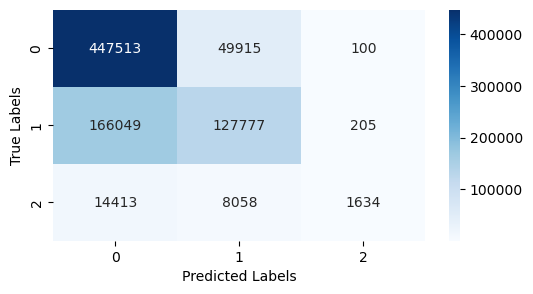

In [25]:
plt.figure(figsize = (6,3))
sns.heatmap(metrics.confusion_matrix(y_test, RFn10m24_pred), annot = True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [25]:
RFn02m8 = rfGS3_model
RFn02m8_pred = RFn02m8.predict(X_test)

target_names = ['On_Time', 'Delayed', 'Cancelled']
print(classification_report(y_test, RFn02m8_pred, target_names=target_names))
print(precision_score(y_test, RFn02m8_pred, average='macro'))

              precision    recall  f1-score   support

     On_Time       0.70      0.87      0.78    497528
     Delayed       0.63      0.41      0.50    294031
   Cancelled       0.76      0.09      0.17     24105

    accuracy                           0.68    815664
   macro avg       0.70      0.46      0.48    815664
weighted avg       0.68      0.68      0.66    815664

0.6976595900687325


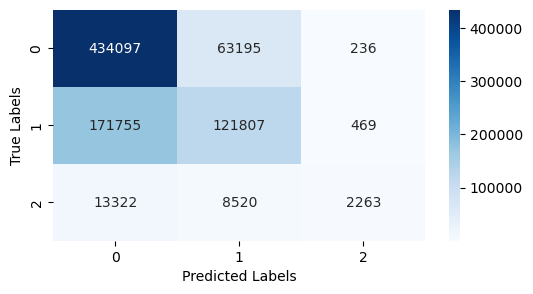

In [26]:
plt.figure(figsize = (6,3))
sns.heatmap(metrics.confusion_matrix(y_test, RFn02m8_pred), annot = True, cmap = 'Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()